# Лабораторная работа 3
## Метод сеток решения одномерного нестационарного уравнения теплопроводности

In [42]:
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy import integrate
import pylab
from mpl_toolkits.mplot3d import Axes3D

### Задание 2

### Получение коэффициентов для трехдиагональной матрицы с помощью метода баланса:

Исходное уравнение теплопроводности:
$$
\begin{cases} -(k(x)*u'(x))' = f, \\ u(a) = U_a, \\ u(b) = U_b\end{cases}
$$

Интегрируя на [a, b] , получим:

$$
W(a) - W(b) - + \int_a^b f(x)dx = 0
$$
, где 
$$
W(x) = -k(x)u'(x)
$$

На отрезке $[x_{n-0.5}, x_{n+0.5}]$ получаем :

$$
W_{n-0.5} - W_{n+0.5} + \int_{x_{n-0.5}}^{x_{n+0.5}} f(x)dx = 0
$$

Найдём $W_{n-0.5}, W_{n+0.5}$. Для этого проинтегрируем $u'(x)=-\frac{W(x)}{k(x)}$ на отрезке $[x_{n-1}, x_n]$:

$$
u_{n-1} - u_n = \int_{x_{n-1}}^{x_n} \frac{W(x)}{k(x)}dx
$$

Тогда при $x_{n-0.5} \leq x \leq x_{n+0.5}$:

$$
W_{n-0.5} \approx -c_{x_{n-1}, x_n} (y_n-y_{n-1})
$$

$$
W_{n+0.5} \approx -c_{x_n, x_{n+1}} (y_{n+1}-y_{n})
$$
, где
$$
c_{x_1, x_2} = (\int_{x_{x_1}}^{x_2} \frac{dx}{k(x)})^{-1}
$$

#### Получим систему

$$
\begin{cases}(c_{x_{n}, x_{n+1}}(y_{n+1}-y_{n}) -c_{x_{n - 1}, x_n}(y_n-y_{n-1})) = -\varphi_n \\ y_0 = g_1, \\ y_N = g_2 \end{cases}
$$

, где 

$$
\varphi_n = \int_{x_{n-0.5}}^{x_{n+0.5}} f(x)dx
$$

#### Упрощая, получаем

$$
\begin{cases} c_{x_{n - 1}, x_n} y_{n-1} - (c_{x_{n - 1}, x_n} + c_{x_{n}, x_{n+1}}) y_{n} + c_{x_{n}, x_{n+1}} y_{n+1} = -\varphi_n * h^2 \\ y_0 = g_1, \\ y_N = g_2 \end{cases}
$$

In [496]:
Ua, Ub = 0, 5
a, b = 0.5, 1.5
h = (b - a) / 150

f = lambda x: x ** (1 / 2) + 4

k2_values = [
    [1, 1000], 
    [1000, 1],
]

k3_values = [
    [1, 100, 200],         
    [200, 100, 1], 
    [50, 100, 50], 
    [200, 10, 200],
]

def get_k(x, k1, k2, k3=None):
    if k3 is None:
        if a <= x <= (b + a) * 0.5:
            return k1
        return k2
    else:
        if a <= x <= (a + (b - a) / 3):
            return k1
        elif (a + 2 * (b - a) / 3) < x <= b:
            return k3
        return k2

In [497]:
def get_coeff(x1, x2, *k_values):
    return (integrate.quad(lambda x: 1 / get_k(x, *k_values), x1, x2)[0]) ** (-1)

def get_phi(x1, x2):
    return integrate.quad(f, x1, x2)[0]

def get_delta_integral(x, x0, c):
    if abs(x - x0) - h / 2 < 1e-5:
        return c / 2
    elif abs(x - x0) < h/2:
        return c
    return 0

In [498]:
def task2(a, b, Ua, Ub, sources=None, *k_values):
    n = int((b - a) / h) + 1
    
    A = np.zeros((n, n))
    g = np.zeros((n, 1))
    
    A[0, 0] = A[-1, -1] = 1
    g[0] = Ua
    g[-1] = Ub
    x_values = np.linspace(a, b, n)

    for i in range(1, n - 1):
        A[i, i-1] = get_coeff(x_values[i-1], x_values[i], *k_values) 
        A[i, i] = (-get_coeff(x_values[i-1], x_values[i], *k_values) 
                   - get_coeff(x_values[i], x_values[i+1], *k_values))
        A[i, i+1] =  get_coeff(x_values[i], x_values[i+1], *k_values)
        if sources:
            g[i] = -sum(get_delta_integral(x_values[i], x0, ci) for ci, x0 in sources)
        else:
            g[i] = -get_phi(x_values[i] - h/2, x_values[i] + h/2)
    return x_values, np.linalg.solve(A, g)


def show_chart(x, y, label):
    plt.plot(x, y, label=label)
    plt.grid()
    plt.legend()
    plt.xlabel('x', size=14)
    plt.ylabel('u(x)', size=14)
    plt.show()

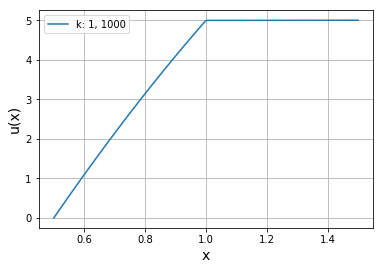

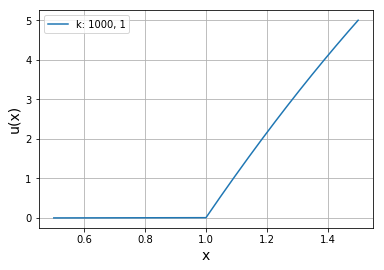

In [499]:
for k1, k2 in k2_values:
    x, y = task2(a, b, Ua, Ub, None, k1, k2)
    show_chart(x, y, f'k: {k1}, {k2}')

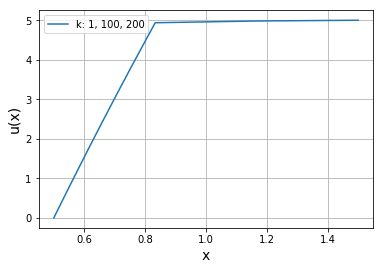

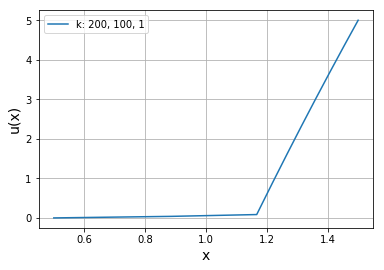

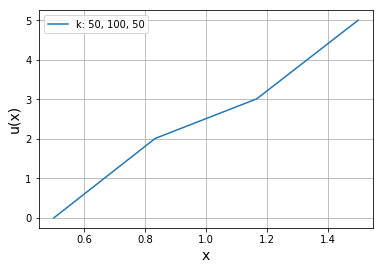

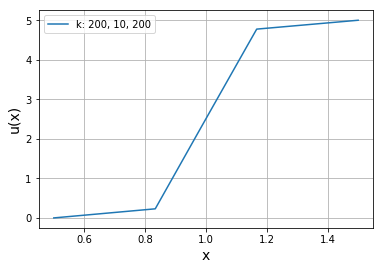

In [500]:
for k1, k2, k3 in k3_values:
    x, y = task2(a, b, Ua, Ub, None, k1, k2, k3)
    show_chart(x, y, f'k: {k1}, {k2}, {k3}')

In [501]:
sources = [
    [(20, a + (b - a) / 2)],
    [(30, a + (b - a) / 4), (30, a + 3 * (b - a) / 4)],
    [(100, a + (b - a) / 4), (20, a + 3 * (b - a) / 4)],
]

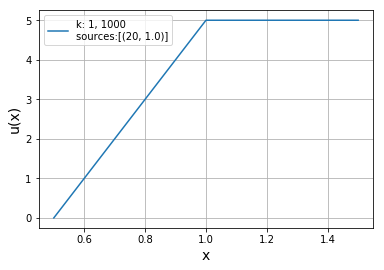

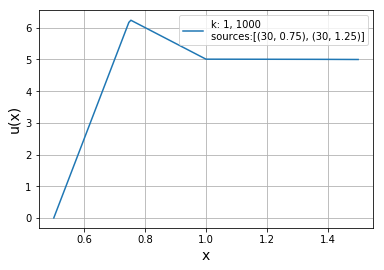

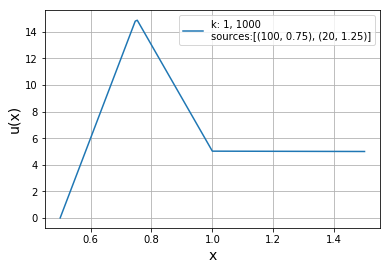

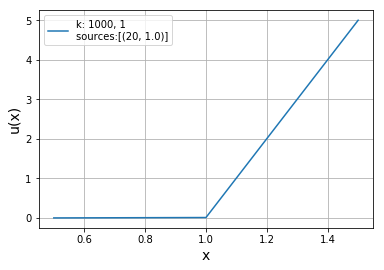

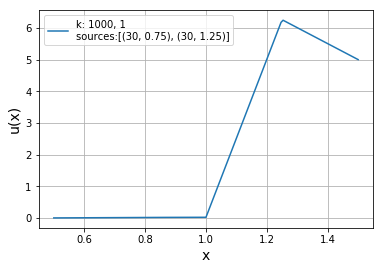

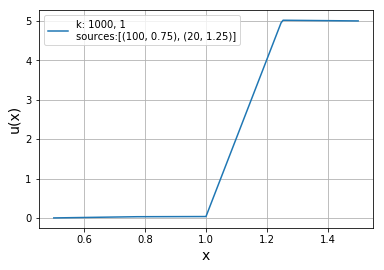

In [502]:
for k1, k2 in k2_values:
    for src in sources:
        x, y = task2(a, b, ua, ub, src, k1, k2)
        show_chart(x, y, f'k: {k1}, {k2}\nsources:{src}')

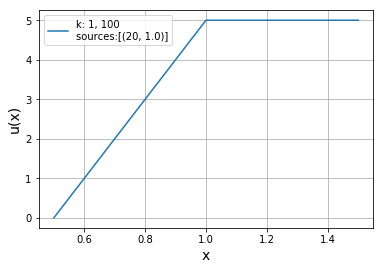

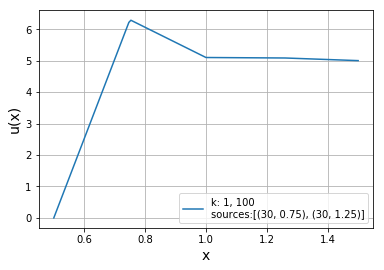

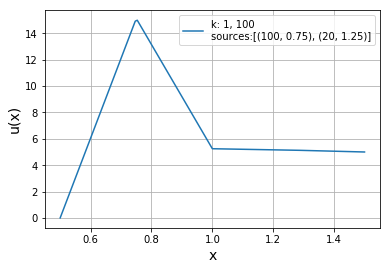

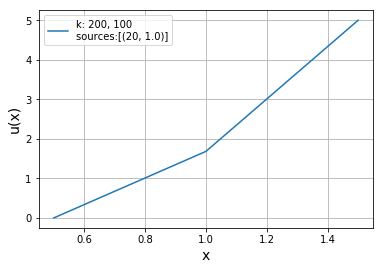

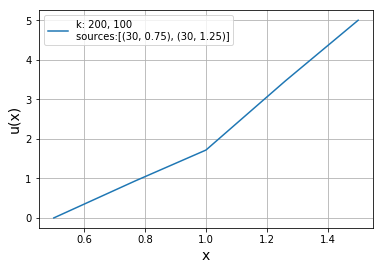

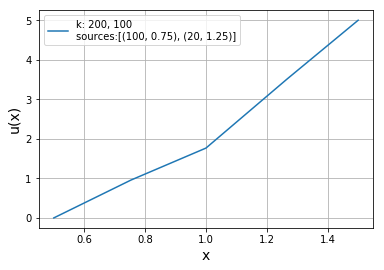

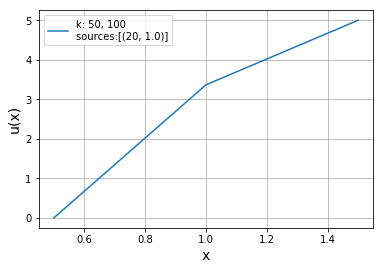

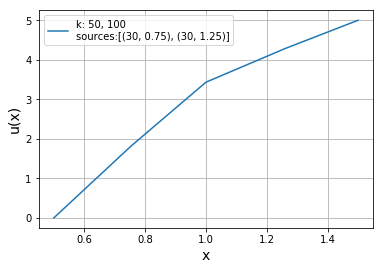

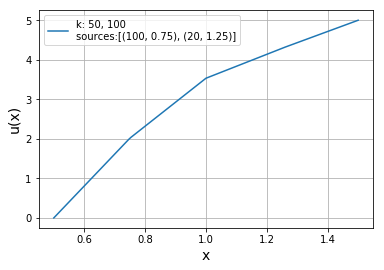

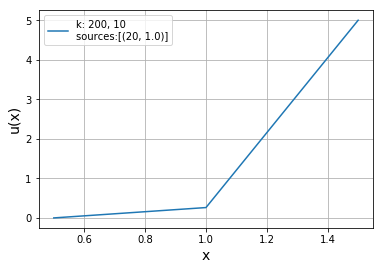

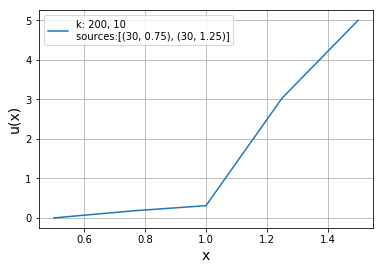

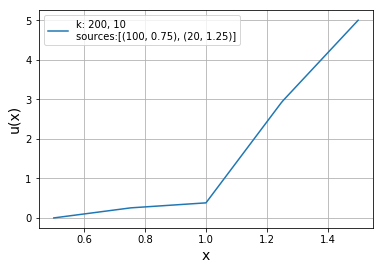

In [503]:
for k1, k2, k3 in k3_values:
    for src in sources:
        x, y = task2(a, b, ua, ub, src, k1, k2)
        show_chart(x, y, f'k: {k1}, {k2}\nsources:{src}')

### Задание 3

Исходное уравнение теплопроводности:
$$
\begin{cases} \frac{\partial u}{\partial t} = \frac{\partial}{\partial x}(k(x)\frac{\partial u}{\partial x}) + f(x)(1 - e ^ t)\\ u(0, t) = U_a, \\ u(l, t) = U_b \\ u(x, 0) = \phi(x) \end{cases}
$$

Используем явную разностную схему:

$$
\frac{\partial u}{\partial t} = \frac{u(x, t + \tau) - u(x, t)}{\tau}
$$

$$
\frac{\partial}{\partial x}(k(x)\frac{\partial u}{\partial x}) = \frac{k(x+\frac{h}{2})u'(x+\frac{h}{2}, t) - k(x-\frac{h}{2})u'(x-\frac{h}{2}, t)}{h}
$$


$$ 
u'(x + \frac{h}{2}, t) = \frac{u(x + h, t) - u(x, t)}{h}
$$

$$ 
u'(x - \frac{h}{2}, t) = \frac{u(x, t) - u(x - h, t)}{h}
$$

Подставляем в исходное уравнение и получаем:

$$
u(x,t+\tau)= \frac{k(x-\frac{h}{2})\tau}{h^2}u(x-h, t) + 
(1 - \frac{(k(x-\frac{h}{2})-k(x+\frac{h}{2}))\tau}{h^2}u(x, t) + \frac{k(x+\frac{h}{2})\tau}{h^2}u(x+h, t) + \tau f(x)(1 - e ^ t)
$$





In [359]:
a, b = 0.5, 1.5
Ua, Ub = 0, 5
k = lambda x: x
f = lambda x: x ** (1 / 2) + 4
h = 0.1
dt = 0.001
t = 500 * dt

def task3(phi):
    nt = int(t / dt) + 1
    nx = int((b - a) / h) + 1
    x_values = np.linspace(a, b, nx)
    t_values = np.linspace(0, t, nt)
    A = np.zeros((nt, nx))
    A[:, 0] = Ua
    A[:, -1] = Ub
    A[0] = [phi(x) for x in x_values]
    
    for i in range(nt - 1):
        for j in range(1, nx - 1):            
            A[i + 1, j] = dt * k(x_values[j] - h / 2) / (h ** 2) * A[i, j - 1] + \
                          (1 - dt * (k(x_values[j] - h / 2) + k(x_values[j] + h / 2)) / (h ** 2)) * A[i, j] + \
                          dt * k(x_values[j] + h / 2) / (h ** 2) * A[i, j + 1] + \
                          dt * f(x_values[j])*(1 - math.exp(-t_values[i]))
    return x_values, t_values, A

In [375]:
def show_plots(x, A, t_values):
    for i in t_values:
        plt.plot(x, A[i], label=fr't={i}$\tau$')
    plt.grid()
    plt.legend()
    plt.xlabel('x', size=14)
    plt.ylabel('u(x, t)', size=14)
    plt.show()
    
def show_3d_plot(x, t, A):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    for i in range(len(t) - 1, -1, -50):
        y = [i * dt] * len(x)
        z = A[i]
        ax.plot(x, y, z)
    plt.show()

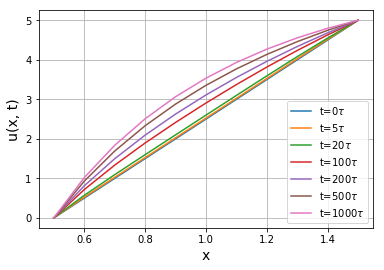

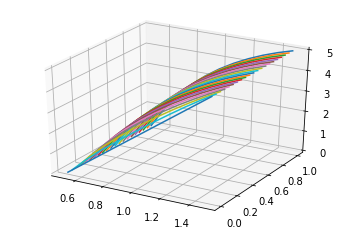

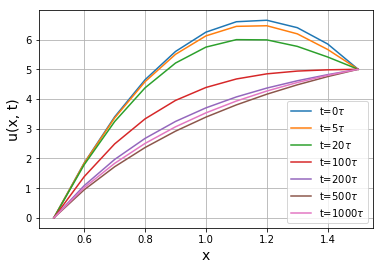

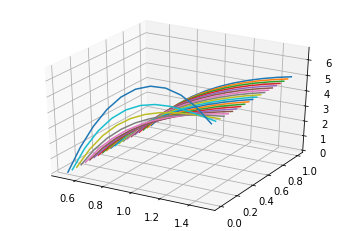

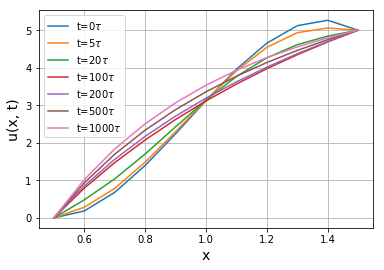

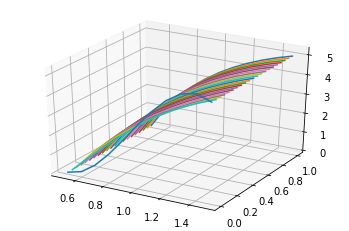

In [376]:
t_values = [0, 5, 20, 100, 200, 500, 1000]
t = 1000 * dt

phi = lambda x: 5 * x - 2.5
x_row, t_row, A = task3(phi)
show_plots(x_row, A, t_values)
show_3d_plot(x_row, t_row, A)

phi = lambda x: -15*(x - 0.5) ** 2 + 20 * (x - 0.5)
x_row, t_row, A = task3(phi)
show_plots(x_row, A, t_values)
show_3d_plot(x_row, t_row, A)

phi = lambda x: -15*(x - 0.5) ** 3 + 20 * (x - 0.5) ** 2
x_row, t_row, A = task3(phi)
show_plots(x_row, A, t_values)
show_3d_plot(x_row, t_row, A)


### Задание 4

Исходное уравнение теплопроводности:
$$
\begin{cases} \frac{\partial u}{\partial t} = k\frac{\partial^2 u}{\partial x^2} + f(x, t)\\ u(0, t) = g_1(t), \\ u(l, t) = g_2(t) \\ u(x, 0) = \phi(x) \end{cases}
$$

Используем явную разностную схему:

$$
\frac{\partial u}{\partial t} = \frac{u(x, t + \tau) - u(x, t)}{\tau}
$$

$$
\frac{\partial^2 u}{\partial x^2} = \frac{u(x+h, t) - 2u(x, t) + u(x-h, t)}{h^2}
$$


Подставляем в исходное уравнение и получаем:

$$
u(x, t + \tau) = \frac{k \cdot \tau}{h^2}u(x-h,t) + (1 - \frac{2 k \cdot \tau}{h^2})u(x,t) + \frac{k \cdot \tau}{h^2}u(x+h, t) + t f(x, t)
$$ 




In [356]:
a, b = -1, 1
Ua, Ub = 0, 5
k = 0.5
f = lambda x, t: x
h = (b - a) / 10
dt = 0.4 * h ** 2 / k 
phi = abs
t = 0.4

def task4():
    nt = int(t / dt) + 1
    nx = int((b - a) / h) + 1
    x_values = np.linspace(a, b, nx)
    t_values = np.linspace(0, t, nt)
    A = np.zeros((nt, nx))
    A[0] = [phi(x) for x in x_values]
    A[:, 0] = Ua
    A[:, -1] = Ub
    
    for i in range(nt - 1):
        for j in range(1, nx - 1):            
            A[i + 1, j] = (k * dt / h ** 2 * A[i, j-1] + (1 - 2 * k * dt / h ** 2) * A[i, j] 
                           + k * dt / h ** 2* A[i, j+1] + dt * f(x_values[j], t_values[i]))
    return x_values, t_values, A

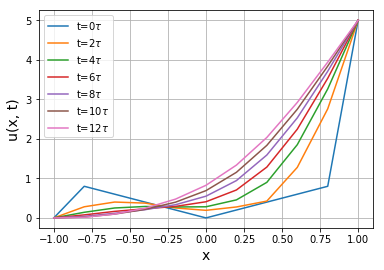

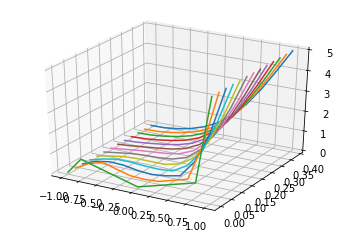

In [357]:
def show_plots(x, A, t_values):
    for i in range(0, int(t / dt) + 1, 2):
        plt.plot(x, A[i], label=fr't={i}$\tau$')
    plt.grid()
    plt.legend()
    plt.xlabel('x', size=14)
    plt.ylabel('u(x, t)', size=14)
    plt.show()
    
def show_3d_plot(x, t, A):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    for i in range(len(t) - 1, - 1, -1):
        x = x
        y = [i * dt] * len(x)
        z = A[i]
        ax.plot(x, y, z)
    plt.show()
    
x_row, t_row, A = task4()
show_plots(x_row, A, t_values)
show_3d_plot(x_row, t_row, A)